# Machine Learning in Python - Project 1

Due Friday, April 9th by 5 pm UK local time.

Abu Mazhar, Adrian Lee, Elliot Kovanda, Gianluca Bianchi.

## 0. Setup

In [162]:
# Install required packages
!pip install -q -r requirements.txt

In [163]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix
from sklearn import utils
from sklearn.metrics import roc_auc_score 

# Other modules
import scipy.stats as st

In [164]:
# Load data
d = pd.read_csv("hotel.csv")

## 1. Introduction
Hotel rooms are typically booked well in advance of the visit. The lead-time between the booking and scheduled stay is usually many months, occasionally over a year long. While this long planning horizon may allow hotel owners to schedule their staff and adjust their pricing optimally, the opposite is often the case: Hotels hold back rooms for extended periods however, a significant proportion of customers cancel short-term or do not show up for their booking. Since hotel rooms are essentially a perishable product with no value once each day has passed, any cancellations that cannot be filled constitute lost revenue for the hotel. Predicting which customers are likely to cancel their booking would allow hotels to respond effectively and gain a competitive advantage. 
 
In this report we developed a machine learning model which predicts whether a customer is likely to cancel their booking. The hotel bookings data set published by Antonio, Almeida and Nunes (2019) was used to train and evaluate the model. This data contains around 120,000 individual bookings made at two Portuguese hotels between 2015 and 2017. The data is labelled, showing for each booking whether or not it was cancelled. Additionally, the data contains 29 features such as the price and time of the booking, details on the guests, their requests and the sales channels to name a few. The challenge is to develop a classification model that has high performance but remains explainable, thereby allowing the hotel owners to respond to predicted cancellations and deploy strategies to reduce cancellation rates in future.     

Before the model was devloped and evaluated we cleaned the data. This included removing unplausible observations such as bookings for 0 guests or no fees. We engineered additional features, including a relative price index which denotes each the price paid compared to similar bookings. Further exploratory data analysis revealed several features were biased or unrelated to the outcome variable. These were hence removed beforehand.  

Having created a high-quality dataset we fitted several models, namely logistic regressions, decision trees and random forests. We focused on the AUC metric to evaluate models but also examined accuracy and precision for better context.  Ultimatley we decided that a regularized logistic regression model provided the best predictions. This model has a high cross-validated AUC of 0.835 and provides a good balance between false positives and false negatives. The cross-validated accuracy is at 0.803 and precision is 0.851. Specific features related to cancellations are the cancellation history of the customer, the refund type, the number of special requests and the lead time. Sensibly, customers who had cancelled previously are more likely to cancel again and vice versa. Interestingly, non-refundable bookings were more likely to be cancelled. This is counterintuitive and may be better explained by a third factor which distuishes non-refundable bookings from refundable ones. Finally, as lead-time increases so does the likelihood of a cancellation while cancellations decrease as customers make more special requests. Both of these relationships appear plausible. 

We believe that this model will allow hotels to predict which customers are particularly likely to cancel their bookings. Thereby, hotels can make special offers to these customers to make them stay. Additionally, hotels can predict the number of total cancellations at any time and adjust their overbooking strategy accordingly. Finally, some insights can be gain to drive strategic changes in order to reduce cancellation rates long-term. Using these analysis, hotels can ultimately reduce vacancies and gain a competitive advantage.

## Exploratory Data Analysis and Feature Engineering

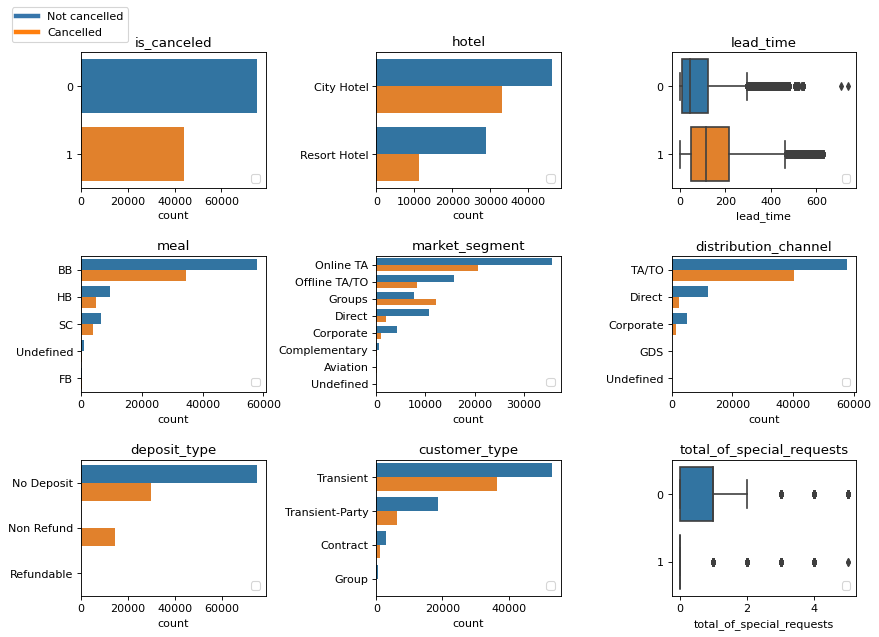

In [70]:
# Select columns for plotting
selected_cols = ['is_canceled', 'hotel', 'lead_time', 
                 'meal', 'market_segment', 'distribution_channel', 
                 'deposit_type', 'customer_type', 'total_of_special_requests']

# Create plot
fig, axs = plt.subplots(3, 3, figsize = (12.5, 9), sharex=False, sharey=False, 
                        gridspec_kw={'hspace': 0.5, 'wspace': 0.6})

h = 0 # Initialise plot number for iteration below

for col in selected_cols:
    
    # row number
    i = h // 3
    # col number
    j = h % 3
    
    if col == 'is_canceled':
        sns.countplot(ax = axs[i,j], y = 'is_canceled', data = d)
        
    elif col != 'is_canceled':
        if d[col].dtypes == 'O':            
            sns.countplot(ax = axs[i,j], y = col, data = d, hue = 'is_canceled',
                          order = d[col].value_counts().sort_values(ascending=False)[:15].index.to_list())

        elif (d[col].dtypes == 'int64') | (d[col].dtypes == 'float64'):
            sns.boxplot(ax = axs[i,j], x = col, y = 'is_canceled', data = d, orient = 'h')
    
    axs[i,j].set_title(col);
    axs[i,j].set_ylabel(None);
    axs[i,j].legend('', loc = 'lower right');
    
    h += 1
    
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='#3776ab', lw=4),
                Line2D([0], [0], color='#ff7f0e', lw=4)]

fig.legend(custom_lines, ['Not cancelled', 'Cancelled'], loc = 'upper left', bbox_to_anchor = (0.05, 0.95))

plt.show();

In [168]:
# Select columns for plotting
selected_cols = ['is_canceled', 'hotel', 'lead_time', 
                 'meal', 'market_segment', 'distribution_channel', 
                 'deposit_type', 'customer_type', 'total_of_special_requests']

# Create plot
fig, axs = plt.subplots(3, 3, figsize = (12.5, 9), sharex=False, sharey=False, 
                        gridspec_kw={'hspace': 0.5, 'wspace': 0.6})

h = 0 # Initialise plot number for iteration below

for col in selected_cols:
    
    # row number
    i = h // 3
    # col number
    j = h % 3
    
    if col == 'is_canceled':
        sns.countplot(ax = axs[i,j], y = 'is_canceled', data = d)
        
    elif col != 'is_canceled':
        if d[col].dtypes == 'O':            
            sns.countplot(ax = axs[i,j], y = col, data = d, hue = 'is_canceled',
                          order = d[col].value_counts().sort_values(ascending=False)[:15].index.to_list())

        elif (d[col].dtypes == 'int64') | (d[col].dtypes == 'float64'):
            sns.boxplot(ax = axs[i,j], x = col, y = 'is_canceled', data = d, orient = 'h')
    
    axs[i,j].set_title(col);
    axs[i,j].set_ylabel(None);
    axs[i,j].legend('', loc = 'lower right');
    
    h += 1
    
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='#3776ab', lw=4),
                Line2D([0], [0], color='#ff7f0e', lw=4)]

fig.legend(custom_lines, ['Not cancelled', 'Cancelled'], loc = 'upper left', bbox_to_anchor = (0.05, 0.95))

plt.show();# res_book_year = d.loc[(d["hotel"] == "Resort Hotel")].groupby("arrival_date_year")["hotel"].count()
# res_cancel_year = d.loc[(d["hotel"] == "Resort Hotel")].groupby("arrival_date_year")["is_canceled"].sum()
    
# cit_book_year = d.loc[(d["hotel"] == "City Hotel")].groupby("arrival_date_year")["hotel"].count()
# cit_cancel_year = d.loc[(d["hotel"] == "City Hotel")].groupby("arrival_date_year")["is_canceled"].sum()
   
# res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
#                                 "Year": list(res_book_year.index),
#                                 "Bookings": list(res_book_year.values),
#                                 "Cancelations": list(res_cancel_year.values)})

# cit_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
#                                 "Year": list(cit_book_year.index),
#                                 "Bookings": list(cit_book_year.values),
#                                 "Cancelations": list(cit_cancel_year.values)})

# all_cancel = pd.concat([res_cancel_data,cit_cancel_data],ignore_index = True)
# all_cancel["cancel_percent"] = all_cancel["Cancelations"]/all_cancel["Bookings"]*100

# sns.barplot(x='Year',y='cancel_percent',hue='Hotel',data=all_cancel)
# plt.title('Yearly Cancellations')
# plt.ylabel('Cancellation Percentage')
# plt.show()

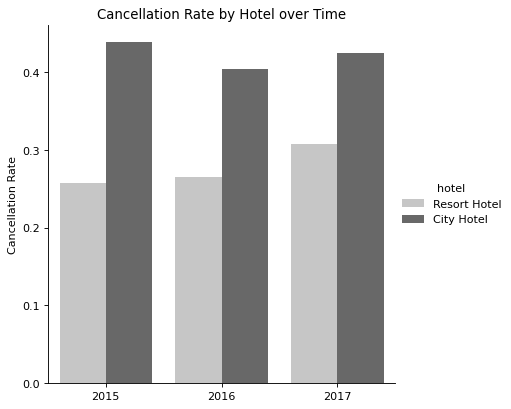

In [169]:
# Improved code for cancellations plot
sns.catplot(
    data = d,
    x = "arrival_date_year",
    y = "is_canceled",
    hue = "hotel",
    kind = "bar",
    palette = "Greys",
    ci = False
).set(title='Cancellation Rate by Hotel over Time', 
      xlabel='', 
      ylabel='Cancellation Rate')

### Guest Data Irregularities


An initial check on our data to decide if a given booking was valid or not was to check that there were the correct number of guests on a booking. This first involved removing bookings with no guests at all. We then proceeded to remove all bookings which contain no adults as we thought this unreasonable for children to be making bookings without adults.

In [170]:
# Total guests 
d["n_guests"] = d.adults + d.children + d.babies

# Drop if no guests
d.drop(d[(d.n_guests < 1) | (np.isnan(d.n_guests))].index, inplace = True)

# # Drop if baby but no adult
d.drop(d[(d.adults < 1) & (d.babies >= 1)].index, inplace = True)

# Assume no children if `children` is nan
d['children'] = d['children'].fillna(0)

# Assume no babies if `babies` is nan
d['babies'] = d['babies'].fillna(0)

# # Bookings with only children
d[(d.adults < 1) & (d.children >= 1)]

#drop entries with no adults
d = d[~(d.adults==0)]

Finally we decided to join the children and baby variable into a 'family' variable.

In [171]:
d['family'] = ((d['children'] > 0) | (d['babies'] > 0))

<ipython-input-171-1e6e4e90eeac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['family'] = ((d['children'] > 0) | (d['babies'] > 0))


For the `adr` column, we removed rows with an Average Daily Rate of 0 as this would also be infeasible.

In [172]:
# drop entries with `adr` == 0
d = d[~(d.adr==0)]

Following the elimination of the invalid rows, we could make more eliminations by considering the parking space requirement for each booking. We said that it was reasonable for each adult on a booking to have their own car parking space, or not have one at all. However, if there was more than one parking space per adult this would be infeasible. We subsequently removed those columns.

In [173]:
# drop entries with more than one car parking space requested per adult (7 in total)
d = d[~(d.required_car_parking_spaces/d.adults > 1)]

#### Agent and Company 

From Antonio, Almeida and Nunes (2017) paper we found that all the Nan values in the `company` and `agent` column were from the same agent or company. Thus we replaced the Nan values accordingly with a new value.

In [174]:
# Fill nan's in the `agent` column with 536 (original range of codes for `agent` is 1 to 535)
d['agent'] = d['agent'].fillna(536)
# Fill nan's in the `company` column with 444 (original range of codes for `company` is 6 to 543)
d['company'] = d['company'].fillna(544)

#### Total stay and weekday_stay per weekend_stay
Delete obervations when total stay = 0

Long stays appear to check out. At least they are staying continouously for weekdays and weekends.

In [175]:
d["total_stay"] = d.stays_in_weekend_nights + d.stays_in_week_nights

d.drop(d[(d.total_stay < 1)].index, inplace = True)

# Weekday_diff indicates whether stay was continuous (weekdays per weekends should be constant and not above 5)
d["weekday_diff"] = (d.stays_in_weekend_nights - d.stays_in_week_nights) / (1+(0.5*d.stays_in_weekend_nights)) 
#d2[((d2.total_stay > 20) & (d2.weekday_diff < -3))]

In [176]:
# Creates a binary column whether booking is from Portugal or not 
d['is_portugal'] = np.where(d.country == 'PRT', 1, 0)

print(d.groupby(["is_portugal", "hotel"]).is_canceled.mean())
print(d.is_canceled.mean())

is_portugal  hotel       
0            City Hotel      0.269590
             Resort Hotel    0.165445
1            City Hotel      0.667246
             Resort Hotel    0.431115
Name: is_canceled, dtype: float64
0.3748762502987062


In [177]:
d.drop(["country", "is_portugal"], axis = "columns", inplace = True)

#### Cancellation ratio
Gives insight into fraction of bookings cancelled. 

Problem: 2 cancellations / 2 bookings = 1 cancellation / 1 booking = 1

In [178]:
d["cancelation_ratio"] = d.previous_cancellations / (d.previous_cancellations + d.previous_bookings_not_canceled)
#d2.cancelation_ratio

#d2["cancelation_ratio"] = d2.previous_cancellations / (d2.previous_cancellations + d2.previous_bookings_not_canceled)
d["cancelation_ratio"] = np.where(d.is_repeated_guest == 0, 0,
                                   d.previous_cancellations / (d.previous_cancellations + d.previous_bookings_not_canceled))

#d2.cancelation_ratio.unique

#### Customer's lead time
Time between confirmation of booking and arrival. 

Problem: There's little variance in waiting time and waiting time is small relative to lead time. Therefore, near perfect correlation between lead_time and customers_lead.


In [179]:
import scipy

d["customers_lead"] = d.lead_time - d.days_in_waiting_list

#d2.customers_lead.mean()
#d2.days_in_waiting_list.mean()

#scipy.stats.pearsonr(d2.customers_lead, d2.lead_time)

In [180]:
d["ppp"] = d.adr / (d.adults + d.children)

#d2.ppp.nlargest(5)
#d2.adr.nlargest(5)

# We drop the excessive ppp > 2000
#d2.drop(d2[(d2.ppp > 2000)].index, inplace = True)


#d2[(d2.ppp > 250)]

### Room Type, Allocation and Price

First we studied the avergae price per person 
per night for each of the different room types. The table below shows reasonable results for all rooms types except room type L. We thus choose to drop all features with room type L.

In [181]:
d.groupby("assigned_room_type").ppp.mean().sort_values()

assigned_room_type
L     4.000000
I    46.113427
C    47.785518
H    52.349578
B    55.424493
A    55.505688
D    55.722988
G    59.340325
F    60.263067
E    61.579533
K    65.199925
Name: ppp, dtype: float64

In [188]:
d.drop(d[(d.assigned_room_type == "L")].index, inplace = True)
d.drop(d[(d.reserved_room_type == "L")].index, inplace = True)

An issue we encountered when discussing certain variables was that  of `assigned_room_type`, along with its natural counterpart `reserved_room_type`. If the assigned room is given to the customer at the time of booking, and it does not match the type they reserved, then of course they are likely to cancel. This is provided that the room is worse. There is a possibility that they are assigned a better room, in which case they are probably less likely to cancel.

However, If the assigned room type is given upon arrival, then this variable would have minimal impact on whether a customer is likely to cancel or not as they are already present at the hotel. This ambiguity when creating an `assigned_vs_reserved` feature means that we cannot consider it further.

In [183]:
# Compare whether assigned and reserved rooms are the same
d['assigned_vs_reserved'] = (d['assigned_room_type'] == d['reserved_room_type'])

Below the seasonality of the price per person and the number of guests is explored. Unsurprisingly we see the peak of both in the summer season. We decided to further explore this price change by making it relative to give a better idea of people got a reasonable price for the time they booked.

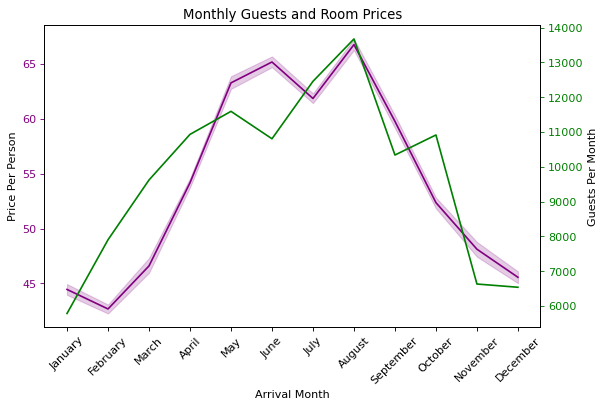

In [184]:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
d['arrival_date_month'] = pd.Categorical(d['arrival_date_month'], categories = ordered_months)


plt.xticks(rotation=45)
plt.tick_params(colors='purple',axis = 'y')
plt.title('Monthly Guests and Room Prices')
ax1 = sns.lineplot(x='arrival_date_month', y = 'ppp', data = d,color = 'purple')
ax1.set(xlabel='Arrival Month', ylabel='Price Per Person')
ax2 = ax1.twinx()
ax2.set_ylabel('Guests Per Month')
d.groupby('arrival_date_month')['arrival_date_month'].count().plot(kind='line',color = 'g')
ax2.tick_params(colors='g')


plt.show()

Along with the arrival date month there are several other features we could consider in order to create a `relative_ppp` feature. This feature will aim to capture the price person relative to similar bookings made.

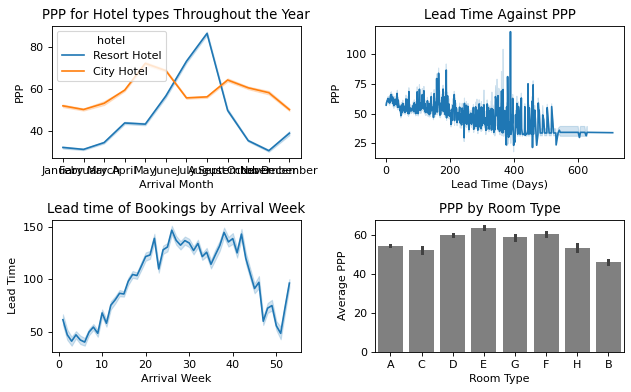

In [189]:
fig,axes = plt.subplots(2,2)

g1 = sns.lineplot(
    data = d,
    x = "arrival_date_month",
    y = "ppp",
    hue = "hotel",
    ax=axes[0,0]).set(title = 'PPP for Hotel types Throughout the Year',xlabel = 'Arrival Month', ylabel = 'PPP')

g2 = sns.lineplot(
    data = d,
    x = "lead_time",
    y = "ppp",
    ax=axes[0,1]
           ).set(title = 'Lead Time Against PPP',ylabel = 'PPP', xlabel = 'Lead Time (Days)')

g3 = sns.lineplot(
    data = d,
    x = "arrival_date_week_number",
    y = "lead_time",
    #hue = "hotel",
    ax=axes[1,0]).set(title = 'Lead time of Bookings by Arrival Week',ylabel='Lead Time',xlabel = 'Arrival Week')

g4 = sns.barplot(
    data = d,
    x = "reserved_room_type",
    y = "ppp",
    #hue = "hotel",
    color = "grey"
           ).set(title='PPP by Room Type', 
      xlabel='Room Type', 
      ylabel='Average PPP')

plt.tight_layout()
plt.show()

The first graph we see above shows the disparity between the PPP for the different types of hotels at different times of the year. This is clearly seen in the peak season, when the Resort Hotel has prices much higher that the City Hotel. 

The top right graph shows that in general, bookings with a shorter lead time (less than 50 days) tend to be slightly more expansive than the rest. There is of course the noticeable exception of the large spike at around 400 days lead time, likely to be an outlier. It is then interesting to note that shorter lead time bookings are made predominantly in the cheaper off season, as noted in the bottom left graph. The spikes in the previous graph are likely caused by a few short lead time peak-season bookings which will be more expensive. 

In [191]:
# Creating a new variable that categorises lead time.
# This can later be used to group-by.
d["lead_cat"] = np.where(d.lead_time < 50, "short", np.where(d.lead_time < 200, "medium", "long"))

d.lead_cat
# Get the means for each type of booking
ppp_ref = d.groupby(["hotel", "arrival_date_month", "lead_cat"]).ppp.mean()
ppp_ref.columns = ['hotel', 'arrival_date_month', 'lead_cat']

ppp_ref = ppp_ref.reset_index()

ppp_actual = d[["hotel", "arrival_date_month", "lead_cat", "ppp"]]

# Create an ID column for the merge
ppp_ref["ppp_ID"] = ppp_ref["hotel"].astype(str) + ppp_ref["arrival_date_month"].astype(str) + ppp_ref["lead_cat"].astype(str)
ppp_actual["ppp_ID"] = ppp_actual["hotel"].astype(str) + ppp_actual["arrival_date_month"].astype(str) + ppp_actual["lead_cat"].astype(str)

# Drop unnecessary columns from reference frame
ppp_ref.drop(["hotel", "arrival_date_month", "lead_cat"], axis = "columns", inplace = True)

# Merge the two data frames 
ppp_joined = pd.merge(ppp_actual, 
                     ppp_ref, 
                     on ='ppp_ID', 
                     how ='left')
# Computes the actual price relative to the expected (mean) price for a booking of that category
ppp_joined["relative_ppp"] = ppp_joined.ppp_y / ppp_joined.ppp_x

d.reset_index(inplace = True)

# We add the new column to the existing data frame
d["relative_ppp"] = ppp_joined.relative_ppp

<ipython-input-191-c041daf3b5a5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppp_actual["ppp_ID"] = ppp_actual["hotel"].astype(str) + ppp_actual["arrival_date_month"].astype(str) + ppp_actual["lead_cat"].astype(str)


In [ ]:
d2 = d.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month','children','babies','reserved_room_type','assigned_room_type','agent','company',
        'required_car_parking_spaces','n_guests','weekday_diff','cancelation_ratio'], axis=1)

## Model Fitting and Tuning

Initially, we explored three different types of models: decision tree, random forest, and logistic regression. 

To start with, the optimised decision tree had a `max_depth` of 13. On the other hand, the random forest containing 1000 trees had a `max_depth` of 31. Noteworthily, cost-complexity pruning worsened both models, meaning it possibly resulted in underfitting, hence `ccp_alpha` was kept at 0. Subsequently, the AUCs for the two models were 0.881 and 0.923 respectively, with the random forest model showing a comparable performance with the results in Antonio, Nuno & De Almeida, Ana & Nunes, Luís. (2017), i.e. an AUC of 0.877 to 0.934. 

The remaining model, logistic regression, was optimised on the norms used in the penalisation, in addition to the (inverse of the) regularisation strengths (C). We experimented with no regularisation, as well as L1, L2, and elasticnet (a combination of L1 and L2 regularisation) regularisations. Using regularisation led to a slightly improved performance (measured in AUC), hence we decided to experiment with different penalty terms. For elastic net, L1:L2 regularisation ratios also had to be experimented with, using the `L1_ratio` argument. As a side note, different solvers had to be adopted for different penalty norms: lbfgs for no penalty, liblinear for L1 and L2, and saga for elasticnet. In the end, the logistic model showed an AUC of 0.835, which was the worst out of the three. However, we chose this model as explained subsequently. 

Unfortunately, the obtained decision tree and random forest suffered from low interpretability. As for the decision tree, while it was possible to visualise the decision tree to determine the decision paths of the model, it was difficult to interpret the effects of all variables due to the depth of the model. Additionally, it would be virtually impossible to investigate the directions of each variable towards the prediction, or in other words, whether each variable would increase or decrease the predicted probabilities when they are singled out. Meanwhile, as an ensemble model, random forest also suffers from low interpretability. Even though we could infer how important different features were to our model, we cannot investigate whether each variable would increase or decrease the predicted probabilities. This leads us to choosing the logistic regression model, which is the most interpretable, as we could interpret how much each variable would contribute to future predictions and in which direction, despite the fact that it was the least accurate out of all three.

In [ ]:
list(d2.columns)

In [ ]:
perc_missing_data = pd.DataFrame([d2.isnull().sum(),d2.isnull().sum()*100.0/d2.shape[0]]).T
perc_missing_data.columns = ['No. of Missing Data', '% Missing Data']
perc_missing_data

In [133]:
y = d2.is_canceled
X = pd.get_dummies(d2.drop(["is_canceled"], axis=1), drop_first=True)

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=1)

In [146]:
# Logistic Regression with elasticnet regularisation
pipeline = Pipeline([('StandardScaler', StandardScaler()), 
                     ('LogisticRegression', LogisticRegression(multi_class='ovr', solver='saga', 
                                                               max_iter=1000))])

params = {'LogisticRegression__C': [0.01, 0.1, 1, 10, 100, 200, 500, 
                                    1000, 2000, 5000, 10000, 100000],
          'LogisticRegression__penalty': ['elasticnet'], 
          'LogisticRegression__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]}

KF = KFold(n_splits = 5, shuffle = True, random_state = 1)

model_LR_elasticnet = GridSearchCV(pipeline, params, cv = KF, scoring = 'roc_auc').fit(X_train, y_train)

In [147]:
print(model_LR_elasticnet.best_estimator_)
print(model_LR_elasticnet.best_score_)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('LogisticRegression',
                 LogisticRegression(C=500, l1_ratio=0.5, max_iter=1000,
                                    multi_class='ovr', penalty='elasticnet',
                                    solver='saga'))])
0.8353118612984435


In [137]:
# Logistic Regression with l1 or l2 regularisation
pipeline = Pipeline([('StandardScaler', StandardScaler()), 
                     ('LogisticRegression', LogisticRegression(multi_class='ovr', solver='liblinear'))])

params = {'LogisticRegression__C': [0.01, 0.1, 1, 10, 100, 200, 500, 
                                    1000, 2000, 5000, 10000, 100000], 
          'LogisticRegression__penalty': ['l1', 'l2']}

KF = KFold(n_splits = 5, shuffle = True, random_state = 1)

model_LR = GridSearchCV(pipeline, params, cv = KF, scoring = 'roc_auc').fit(X_train, y_train)

In [138]:
print(model_LR.best_estimator_)
print(model_LR.best_score_)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('LogisticRegression',
                 LogisticRegression(C=1000, multi_class='ovr', penalty='l1',
                                    solver='liblinear'))])
0.8353472352871879


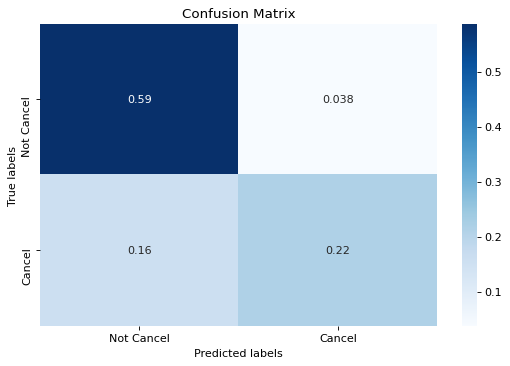

In [145]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, model_LR.predict(X_train))/len(y_train), annot = True, cmap="Blues");
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Cancel', 'Cancel']); ax.yaxis.set_ticklabels(['Not Cancel', 'Cancel']);

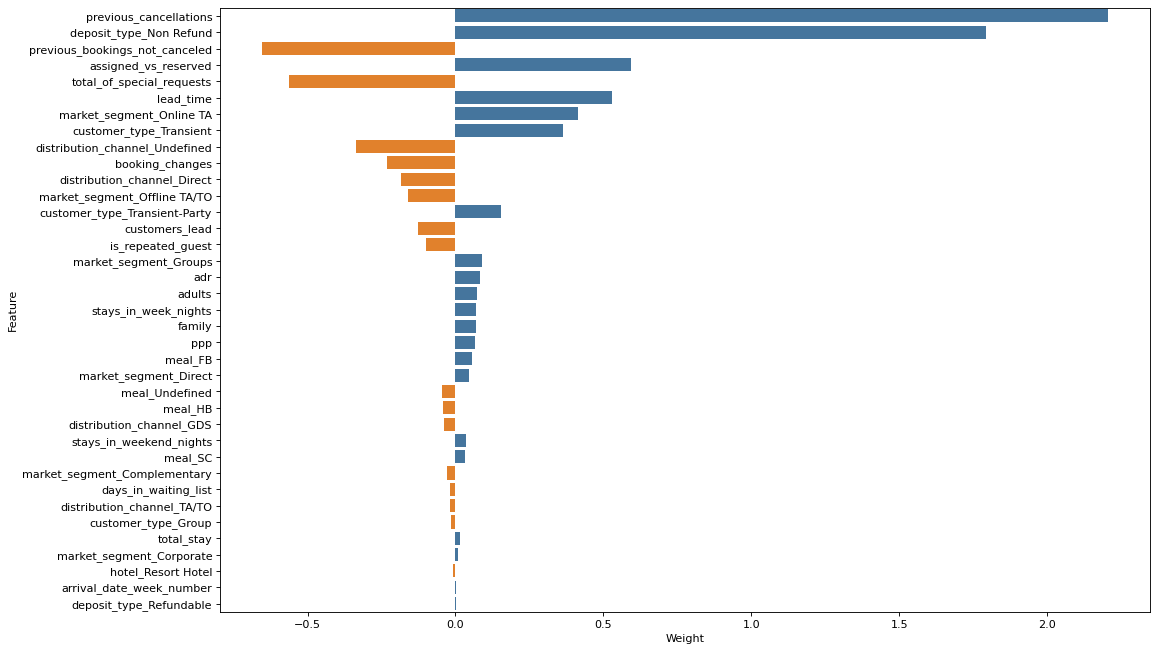

In [127]:
plt.figure(figsize=(15,10))
# Logistic regression weights
model_LR_weights = pd.DataFrame({'Feature': X_train.columns, 
                                 'Weight': model_LR.best_estimator_.named_steps['LogisticRegression'].coef_[0], 
                                 'abs_weight': abs(model_LR.best_estimator_.named_steps['LogisticRegression'].coef_[0])})

# Sort weights by absolute values
model_LR_weights = model_LR_weights.sort_values(by='abs_weight', ascending=False).drop(['abs_weight'], axis=1)

# Specify colors for positive and negative values
colors = ['#ff7f0e' if x < 0 else '#3776ab' for x in model_LR_weights.Weight]

sns.barplot(y = 'Feature', x = 'Weight', data = model_LR_weights, palette = colors)
plt.show();

In [143]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

In [170]:
print('Accuracy:', accuracy_score(y_train, model_LR.best_estimator_.predict(X_train)))
print('Precision:', precision_score(y_train, model_LR.best_estimator_.predict(X_train)))
print('AUC:', roc_auc_score(y_test, model_LR.best_estimator_.predict(X_test)))

Accuracy: 0.8029252368353674
Precision: 0.8526689489032585
AUC: 0.7581561224525356


### Bootstrap Analysis

So far we have focused the reporting of errors using cross validation. This demonstrated the good performance of our model. However, we do not know the variance of this estimate with confidence. Resampling methods can help estimate this variance. Bootstrap analysis can provide a confidence interval around our error estimates. Specifically, by repeatedly resampling with replacement we generate many individual error estimates. We computed 100 such bootstrap estimates and used these to obtain a 95% confidence interval on the AUC. The resulting interval is very narrow indicating excellent reliability of our model. This is helpful because the hotel would like the model to maintain its good performance on novel data. 

In [ ]:
# Initializes a dataframe to take the bootstrap samples from
X_boot = X_train.copy()
X_boot["is_canceled"] = y_train

# Stores the bootstrap samples
boots = []

# Resamples the data with replacements
i = 1
while i <= 100:
    boots.append(utils.resample(X_boot, replace=True, n_samples=len(X_train), random_state=i, stratify=None))
    i += 1

# Stores the AUC for each bootstrap sample
boot_auc = []

# Obtains the AUC for each bootstrap sample 
# by predicting using our model 
i = 0
while i < len(boots):
    boot_auc.append(roc_auc_score(boots[i].is_canceled, model_LR.predict(boots[i].drop("is_canceled", axis = 1))))
    i += 1

# Obtains the 95% confident interval
conf_int = st.t.interval(0.95, len(boot_auc)-1, loc=np.mean(boot_auc), scale=st.sem(boot_auc))

print("The 95% confidence interval is:", round(conf_int[1]-conf_int[0],3))

## Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of the client who is with the hotel data and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

Having explored numerous logistic models, decision trees and random forests, we decided a logistic model would best suit the task at hand. While the random forest has slightly superior performance (AUC = XXX), this gain outweighed by the much improved interpretability of the logistic model. The decision tree model was similarly too deep to interpret meaningfully or too unabalanced in its predictions, excessively minimizing false positives at the expense of false negatives. The logistic model on the other hand provides the best balance between performance and interpretability as well as false positive and false negative errors. 

Specifically, the logistic model achieves a cross-validated AUC of 0.835 which is comparable to Almeida, Antonio and Nunes' (2017a) results using the same data. Overall accuracy is 0.803 and precision is high as well at 0.851. This performance translates reasonably well to unseen test data, achieving a respectable test-AUC of 0.772. Bootstrapping was applied to add a 95% confidence interval on this estimate of the generalization error. Results indicate that the performance is stable with the 95%-CI being $\pm$ 0.001. This shows that the model we developed is both high-performing and reliable. It is worth noting that including the nationality and assigned room variables would improve the model but in fact this information is biased and was disregarded. Similarly, we decided to train a model that predicts both cancellations and non-cancellations reasonably well. If more emphasis were placed on one type of error, this could be improved considerably.

We believe the hotel managers will be particularly interested in three components. What proportion of cancellations is detected, to what extent can these predictions be trusted and finally, which actions should the hotel take. Our model is able to detect most albeit not all cancellations (57.9%). Cancellations that are predicted can, however, be trusted as precision is high (85.1%). This means that the hotel can confidently take mitigating actions: A low-risk low-impact strategy is to attempt to persuade customers which are predicted to cancel to stay. This can be done by offering discounts, upgrades or other special offers. This is low-risk because the investment is minor however also low-impact as many customers may be insensitive to price. Indeed, this is shown by our model as the rate of the booking and in particular the relative price compared to similar bookings is not a significant factor in cancellations. Particularly during periods of high demand, hotels should instead develop their overbooking strategy. This entails offering rooms of customers likely to cancel. Thereby, hotel can effectively prevent revenue loss due to empty rooms. This is however more risky as having insufficient capacity to serve all overbooked customers will result in high costs such as loss of customer loyalty. Therefore, we emphasise that high accuracy is important and allows for such a risky strategy to be taken confidently. 

Finally, the hotel may benefit from understanding what drives cancellations and which long-term strategic changes can be applied to prevent cancellations in future. Our model provides insight to this question as well. Specifically, customers' cancellation history is a the most significant predictor. Sensibly, customers who have cancelled bookings before are likely to do so again and those that have a history of not cancelling their bookings are likely to continue this trend. Hotels should therefore focus their promotions on loyal customers rather than trying to capture customers that have cancelled in the past. Interestingly, non-refundable bookings are more likely to be cancelled. This is counterintuitive and may be better explained by a third factor which distuishes non-refundable bookings from refundable ones. Moreover, as customers' lead-time increases so does the likelihood of a cancellation while cancellations decrease as customers make more special requests. Hotels should therefore possibly limit the period of time customers can book rooms in advance, or send intermittent reminders of their booking. Perhaps asking for special requests closer to the stay can help increase engagement. Finally, it is also interesting to observe which variables are not related to cancellations. Specifically, cancellations are not seasonal and not price sensitive. Hotels can therefore benefit from increasing prices during peak season without fearing increased cancellations.  

In conclusion, we believe that our model is an effective tool to help hotels predict whether individual customers are likely to cancel. Targeted promotional activities can then be applied. Similarly, the hotel can better understand the number of total cancellations and develop a data-driven overbooking strategy to prevent empty rooms. Finally, long-term strategic changes may allow the hotel to prevent cancellations in future. Thus, we believe our model will likely help the hotel gain a competitive advantage.    

## References
Antonio, Nuno & De Almeida, Ana & Nunes, Luís. (2017). Predicting hotel bookings cancellation with a machine learning classification model, in: Proceedings of the 16th IEEE International Conference Machine Learning Application, IEEE, Cancun, Mexicopp. 1049–1054. doi:10.1109/ICMLA.2017.00-11.

Antonio, Nuno & De Almeida, Ana & Nunes, Luís. (2017). Predicting Hotel Booking Cancellation to Decrease Uncertainty and Increase Revenue. Tourism and Management Studies. 13. 25-39. 10.18089/tms.2017.13203.

Antonio, Nuno & De Almeida, Ana & Nunes, Luís. (2018). Hotel booking demand datasets. Data in Brief. 22. 41-49. 10.1016/j.dib.2018.11.126.

## Convert Document

In [639]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf proj2.ipynb

[NbConvertApp] Converting notebook proj2.ipynb to pdf
[NbConvertApp] Support files will be in proj2_files/
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Writing 105690 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 305039 bytes to proj2.pdf
